In [2]:
#ds_key = 'adni-100-csts2'
ds_key = 'adni-csts2-validtest'
from dataset_utils import adni_loader
import vte_runner

eval_data_params = vte_runner.named_vte_data_params[ds_key]
print(eval_data_params)
eval_data_params['load_vols'] = True
eval_ds = adni_loader.ADNIDataset(eval_data_params)
_ = eval_ds.load_dataset()


Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


{'dataset_name': 'adni', 'source_name': 'centroidsubj2', 'target_name': 'subjs', 'final_test': False, 'n_validation': 100, 'valid_split': 0, 'exclude_from_valid_list': 'adni-100-csts2-valid.txt', 'unnormalized': True, 'masked': True, 'n_shot': 100, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 1, 'load_vols': True, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'warp_labels': True, 'n_dims': 3}
Loading adni dataset adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0
Params: {'dataset_name': 'adni', 'source_name': 'centroidsubj2', 'target_name': 'subjs', 'final_test': False, 'n_validation': 100, 'valid_split': 0, 'exclude_from_valid_list': 'adni-100-csts2-valid.txt', 'unnormalized'

KeyboardInterrupt: 

In [40]:
# for f in valid_ds.files_labeled_valid:
#     if f in valid0_ds.files_labeled_valid:
#         print(f)
for f in eval_ds.files_labeled_valid:
    print(f)


/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADNI_ADNI-1.5T-FS-5.3-Long_200434.long.011_S_0241_base_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADNI_ADNI-1.5T-FS-5.3-Long_101774.long.094_S_1314_base_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADNI_ADNI-1.5T-FS-5.3-Long_101933.long.127_S_1419_base_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADNI_ADNI-1.5T-FS-5.3-Long_82120.long.012_S_0803_base_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADHD200_NYU_1737393_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/GSP_100729_AM54XC_FS_mri_talairach_orig.npz
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/validate/origs/ADNI_ADNI-3T-FS-5.3-Long_78935.long.033_S_1279_base_mri_talairach_orig.npz
/data/ddmg/voxel

In [41]:
do_final_test = False

%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader

gpu_ids = [3]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Segmenter experiment

In [42]:
import json
import os
import sys

sys.path.append('../cnn_utils')
import file_utils
from keras.models import load_model

from experiments_VTE import FewShotSegmentationExperimentClass
from keras.models import load_model
from keras.optimizers import Adam

sys.path.append('../voxelmorph')
import src.losses as vm_losses

sys.path.append('../medipy-lib')
import medipy.metrics as medipy_metrics

# load pretrained segmenter network
# ours
#model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1020/models/segmenter_unet_epoch8000_iter56000.h5'
model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010/models/segmenter_unet_epoch4400_iter30800.h5'
model_id = 'ours-indep'

model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_coupled/models/segmenter_unet_epoch5200_iter36400.h5'
model_id = 'ours-coupled'

# # randflow
# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_flowaug-gen/models/segmenter_unet_epoch3600_iter25200.h5'
# model_id = 'hand-aug'

# # # 100 labeled examples
# # model_file = './experiments/FewShotSeg_adni-unnorm-masked_1ul_100l_ims160-192-1_arch32-32-64-64-128-128/models/segmenter_unet_epoch7000_iter49000.h5'
# # model_id = 'supervised'

# # # sas-aug
# # model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_sasaug100-vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000/models/segmenter_unet_epoch3500_iter24500.h5'
# # model_id = 'sas-aug'

# # sas
# model_file = './experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000.h5'
# model_id = 'sas'

# # no-aug
# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128/models/segmenter_unet_epoch2500_iter17500.h5'
# model_id = 'no-aug'

# ours with ft on test set
model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_samp-adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0/models/segmenter_unet_epoch7700_iter53900.h5'
model_id = 'ours-ft'

# model_file = './experiments/FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_flowaug-gen/models/segmenter_unet_epoch9000_iter63000.h5'
# model_id = 'ours-indep-hand-aug'

if 'experiments/voxelmorph' in model_file:  # SAS
    do_sas = True
    sys.path.append('../voxelmorph-sandbox')
    import voxelmorph.networks as vm_networks
    
    import tensorflow as tf
    from voxelmorph import dense_3D_spatial_transformer
    from keras.models import load_model

    sys.path.append('../neuron')
    import neuron.layers as nrn_layers
    import neuron.utils as nrn_utils
    
    import functools


    voxelmorph_model = load_model(
        model_file,
        custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                        'interp_upsampling': vm_networks.interp_upsampling,
                        'meshgrid': vm_networks.meshgrid,
                        'tf': tf,
                        'VecInt': nrn_layers.VecInt,
                        'SpatialTransformer': functools.partial(nrn_layers.SpatialTransformer, indexing='xy'),
                        'nrn_utils': nrn_utils,
                        'nrn_layers': nrn_layers,
                       },
        compile=False,
    )

    model_name = os.path.splitext(os.path.basename(model_file))[0]
else:  # trained segmenter network
    do_sas = False
    model_name = os.path.basename(os.path.dirname(os.path.dirname(model_file))) + '_' + os.path.splitext(os.path.basename(model_file))[0]
    
    segmenter_model = load_model(model_file, custom_objects={'np': np}, compile=False)
    segmenter_model.compile(
        loss='categorical_crossentropy',
        metrics=[vm_losses.binary_dice],
        optimizer=Adam(0.0001),
    )
    
print(model_name)

FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1010_samp-adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0_segmenter_unet_epoch7700_iter53900


['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz']


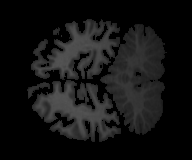

In [43]:
do_final_test = False
# show what our labeled example looks like, as a sanity check
import IPython
import PIL
source_X = eval_ds.X_labeled_train[[0]]#adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_Y = eval_ds.Y_labeled_train[[0]]
print(eval_ds.files_labeled_train)

IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))
if do_final_test:
    print(eval_ds.files_labeled_test[:10])
    IPython.display.display(PIL.Image.fromarray((eval_ds.X_labeled_test[0, :, :, 64, 0]*255).astype(np.uint8)))
    IPython.display.display(PIL.Image.fromarray((eval_ds.Y_labeled_test[0, :, :, 64]*255).astype(np.uint8)))
    print(eval_ds.X_labeled_test.shape)


In [44]:
label_mapping = vte_runner.voxelmorph_labels
from networks import segmenter_networks

# seg_exp.dataset.logger = seg_exp.logger
if do_final_test:
    eval_gen = eval_ds.gen_vols_batch(
            ['labeled_test'], batch_size=1, randomize=False,
    )

    n_eval_examples = eval_ds.params['n_test']

else:
    eval_gen = eval_ds.gen_vols_batch(
            ['labeled_valid'], batch_size=1, randomize=False,
    )

    n_eval_examples = eval_ds.params['n_validation']

if do_sas:
    eval_cces, eval_dice, eval_accs = segmenter_networks.eval_seg_sas_from_gen(
        sas_model=voxelmorph_model,
        atlas_vol=source_X, atlas_labels=source_Y,
        eval_gen=eval_gen, label_mapping=label_mapping,
        n_eval_examples=n_eval_examples, batch_size=10)
else:
    eval_cces, eval_dice, eval_accs = segmenter_networks.eval_seg_from_gen(
        segmenter_model=segmenter_model,
        eval_gen=eval_gen, label_mapping=label_mapping,
        n_eval_examples=n_eval_examples, batch_size=10)



Testing on subject 0 of 100
Sampling size 1 batches from 100 volumes!
0.8553593150945381
Testing on subject 1 of 100
0.858155239025896
Testing on subject 2 of 100
0.8940054910438001
Testing on subject 3 of 100
0.8660408980332708
Testing on subject 4 of 100
0.8490177993992947
Testing on subject 5 of 100
0.8926001429638128
Testing on subject 6 of 100
0.9051458046578837
Testing on subject 7 of 100
0.9038336511568346
Testing on subject 8 of 100
0.8926001069667938
Testing on subject 9 of 100
0.8819754714807296
Testing on subject 10 of 100
0.8907246102487041
Testing on subject 11 of 100
0.9012883706214337
Testing on subject 12 of 100
0.9187889284321531
Testing on subject 13 of 100
0.9076168960966766
Testing on subject 14 of 100
0.9033198059982184
Testing on subject 15 of 100
0.8933262093462753
Testing on subject 16 of 100
0.8873262640010903
Testing on subject 17 of 100
0.9106371987588405
Testing on subject 18 of 100
0.898979746835443
Testing on subject 19 of 100
0.8954668290977981
Testing on

In [45]:
# save our test results in a mat file so that we can parse them later

In [46]:
results_dir = './segmentation_test_results'
if '128' in model_name:
    short_model_name = model_name.split('128-128_')[1]
else:
    short_model_name = model_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
    
if do_final_test:
    mode='test'
else:
    mode='valid'

results_file = os.path.join(results_dir, '{}_{}_{}.mat'.format(eval_ds.display_name, mode, model_id))
print('Saved results to {}'.format(results_file))
import scipy.io as sio


sio.savemat(results_file, {
    'cce': eval_cces,
    'dice': eval_dice,
    'acc': eval_accs
    
})

Saved results to ./segmentation_test_results/adni-unnorm-masked_1ul_subj-OASIS_OAS1_0327-l_validsplit0_valid_ours-ft.mat


In [1]:
import os
n_eval_examples = eval_ds.params['n_validation']
mode='valid'

n_subjects = n_eval_examples
ds_name = '{}_{}_'.format(eval_ds.display_name, mode)
cce_per_result = []
dice_per_result = []
acc_per_result = []
result_names = []
for rfn in os.listdir(results_dir):
    if ds_name not in rfn:
        continue
    
    result = sio.loadmat(os.path.join(results_dir, rfn))
    result_name = os.path.splitext(os.path.basename(rfn))[0]
    result_name = result_name.split('valid_')[-1]
    
    print(result_name)
    print(result['cce'].shape)
    
    # make sure we evaluated on the same number of subjects
    if result['cce'].shape[-1] < n_subjects:
        continue
        
    result_names.append(result_name)
    cce_per_result.append(result['cce'])
    acc_per_result.append(result['acc'])
    dice_per_result.append(result['dice'][np.newaxis])
    
print(result_names)
sort_results_by_name = ['supervised','ours-indep-hand-aug', 'ours-indep','ours-coupled', 'hand-aug', 'sas-aug', 'sas', 'no-aug']

sorted_acc = []
sorted_dice = []
for rn in sort_results_by_name:
    idx = result_names.index(rn)
    sorted_acc.append(acc_per_result[idx])
    sorted_dice.append(dice_per_result[idx])
result_names = sort_results_by_name
# result_names, cce_per_result, acc_per_result, dice_per_result = zip(*sorted(zip(result_names, cce_per_result, acc_per_result, dice_per_result)))

acc_per_result = np.concatenate(sorted_acc, axis=0)
dice_per_result = np.concatenate(sorted_dice, axis=0)


NameError: name 'eval_ds' is not defined

supervised
ours-indep-hand-aug
ours-ft
ours-indep
ours-coupled
hand-aug
sas-aug
sas
no-aug


(9, 100)
(9, 100, 31)
Result supervised, dice mean 0.849, std 0.092
0.849 (0.092)
Result ours-indep-hand-aug, dice mean 0.815, std 0.122
0.815 (0.122)
Result ours-ft, dice mean 0.806, std 0.129
0.806 (0.129)
Result ours-indep, dice mean 0.804, std 0.13
0.804 (0.13)
Result ours-coupled, dice mean 0.795, std 0.133
0.795 (0.133)
Result hand-aug, dice mean 0.765, std 0.143
0.765 (0.143)
Result sas-aug, dice mean 0.769, std 0.146
0.769 (0.146)
Result sas, dice mean 0.758, std 0.138
0.758 (0.138)
Result no-aug, dice mean 0.401, std 0.313
0.401 (0.313)


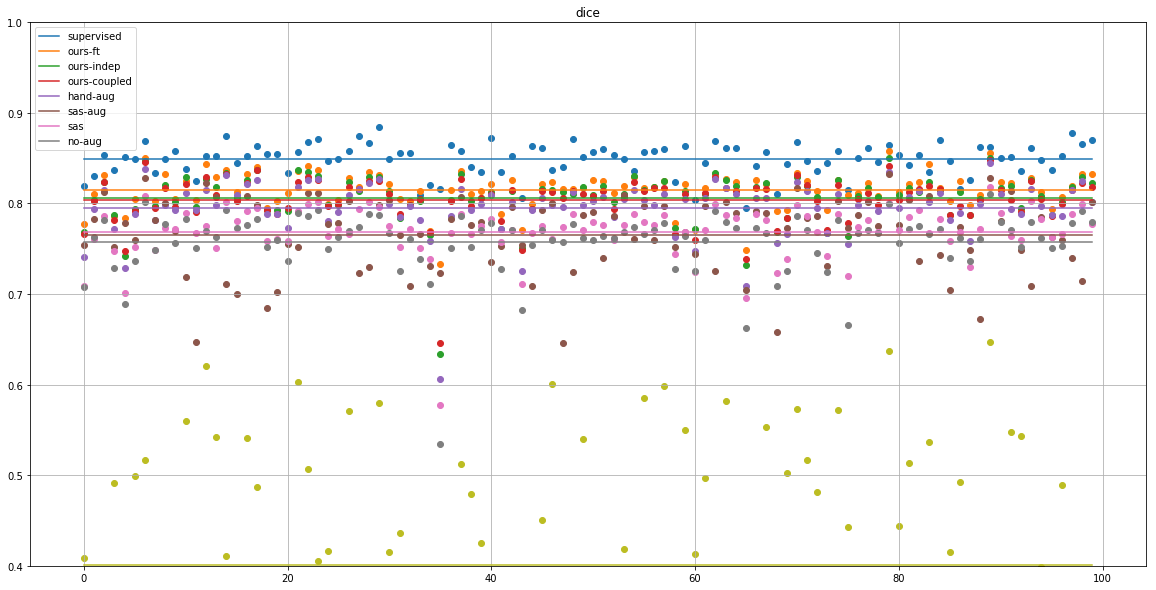

Result supervised, acc mean 0.916, std 0.013
0.916 (0.013)
Result ours-indep-hand-aug, acc mean 0.897, std 0.015
0.897 (0.015)
Result ours-ft, acc mean 0.89, std 0.016
0.89 (0.016)
Result ours-indep, acc mean 0.892, std 0.017
0.892 (0.017)
Result ours-coupled, acc mean 0.885, std 0.018
0.885 (0.018)
Result hand-aug, acc mean 0.888, std 0.024
0.888 (0.024)
Result sas-aug, acc mean 0.859, std 0.016
0.859 (0.016)
Result sas, acc mean 0.812, std 0.018
0.812 (0.018)
Result no-aug, acc mean 0.648, std 0.123
0.648 (0.123)


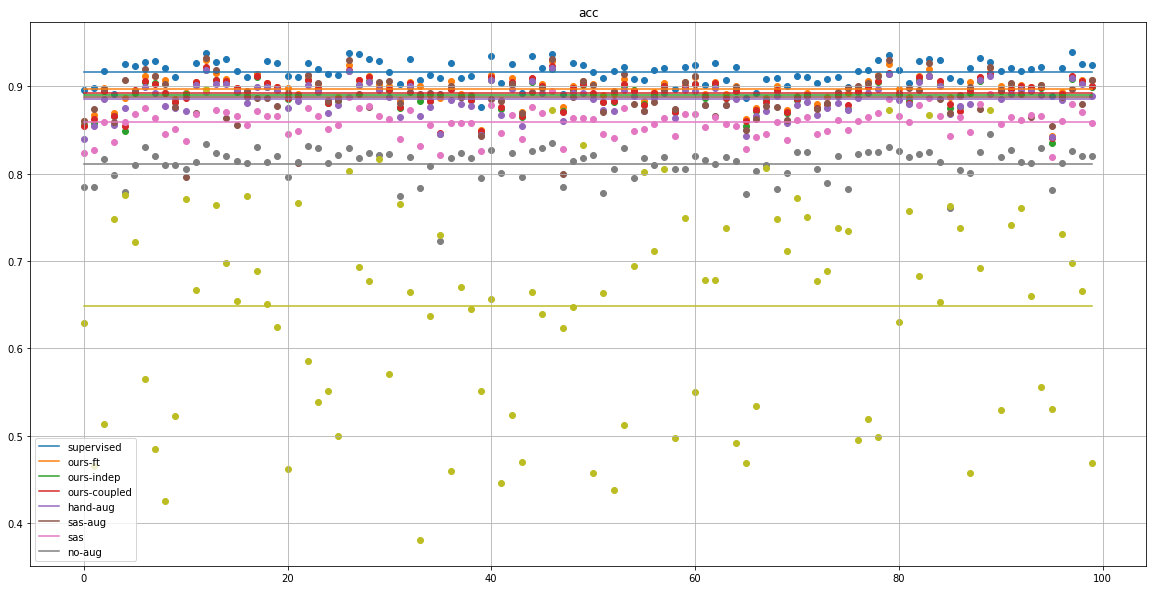

In [49]:
x = np.tile(np.reshape(range(n_subjects), (1, n_subjects)), (len(result_names), 1))
print(acc_per_result.shape)
import matplotlib.pyplot as plt
print(dice_per_result.shape)
plt.figure(figsize=(20,10))
for ri, rn in enumerate(result_names):
    x = range(n_subjects)
    
    plt.scatter(x, np.mean(dice_per_result[ri, :, 1:], axis=-1))
    plt.plot(x, np.tile(np.mean(dice_per_result[ri,:,1:]), (np.asarray(x).shape)))
    print('Result {}, dice mean {}, std {}'.format(rn,
        round(np.mean(dice_per_result[ri,:,1:]), 3), 
                                                   round(np.std(dice_per_result[ri,:,1:]),3)))
    print('{} ({})'.format(
        round(np.mean(dice_per_result[ri,:,1:]), 3), 
        round(np.std(dice_per_result[ri,:,1:]),3)))
    plt.ylim([0.4, 1.])
plt.legend(short_result_names)
plt.title('dice')

plt.grid()
plt.show()

plt.figure(figsize=(20,10))
for ri, rn in enumerate(result_names):
    x = range(n_subjects)
    
    plt.scatter(x, acc_per_result[ri])
    plt.plot(x, np.tile(np.mean(acc_per_result[ri]), (np.asarray(x).shape)))
    print('Result {}, acc mean {}, std {}'.format(rn, round(np.mean(acc_per_result[ri]),3), 
                                                  round(np.std(acc_per_result[ri]), 3)))
    print('{} ({})'.format(
        round(np.mean(acc_per_result[ri]),3), 
        round(np.std(acc_per_result[ri]), 3)))    
plt.legend(short_result_names)

plt.title('acc')
plt.grid()
plt.show()




Result supervised, dice improvement over sas mean 0.088, std 0.072
0.088 (0.072)
Result ours-indep-hand-aug, dice improvement over sas mean 0.055, std 0.044
0.055 (0.044)
Result ours-ft, dice improvement over sas mean 0.047, std 0.036
0.047 (0.036)
Result ours-indep, dice improvement over sas mean 0.045, std 0.038
0.045 (0.038)
Result ours-coupled, dice improvement over sas mean 0.036, std 0.035
0.036 (0.035)
Result hand-aug, dice improvement over sas mean 0.007, std 0.086
0.007 (0.086)
Result sas-aug, dice improvement over sas mean 0.011, std 0.037
0.011 (0.037)
Result sas, dice improvement over sas mean 0.0, std 0.0
0.0 (0.0)
Result no-aug, dice improvement over sas mean -0.346, std 0.271
-0.346 (0.271)


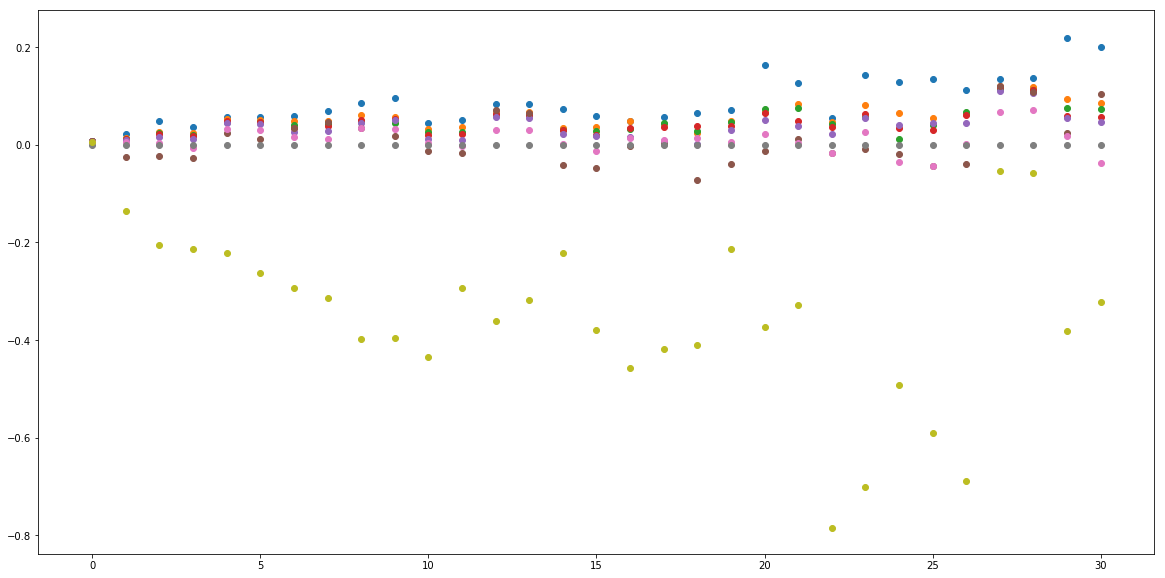

In [60]:
# improvement over sas
plt.figure(figsize=(20,10))
ref_dice = dice_per_result[result_names.index('sas')]
for ri, rn in enumerate(result_names):
    print('Result {}, dice improvement over sas mean {}, std {}'.format(
        rn, round(np.mean(dice_per_result[ri] - ref_dice),3), 
        round(np.std(dice_per_result[ri] - ref_dice), 3)))
    print('{} ({})'.format(
         round(np.mean(dice_per_result[ri] - ref_dice),3), 
        round(np.std(dice_per_result[ri] - ref_dice), 3)))   
    
    %plt.scatter(range(len(label_mapping)),np.mean(dice_per_result[ri] - ref_dice, axis=0))

In [51]:
# print(len(eval_ds.files_labeled_test))
# for f in eval_ds.files_labeled_test:
#     print(os.path.basename(f))

In [52]:
# show_idx = 17
# for i in [1]:#range(100):
#     show_idx = 10
#     print(i)
    
#     print(eval_ds.files_labeled_valid[show_idx])

#     data = np.load(eval_ds.files_labeled_valid[show_idx])
#     im = data['vol_data']
#     plt.imshow((im[:, :, 100]*255).astype(np.uint8))
#     print(eval_ds.X_labeled_valid.shape)
#     #plt.imshow((eval_ds.X_labeled_valid[show_idx, :, :, 100, 0]*255).astype(np.uint8))
#     IPython.display.display(PIL.Image.fromarray((eval_ds.X_labeled_valid[show_idx, :, :, 100, 0]*255).astype(np.uint8)))
#     IPython.display.display(PIL.Image.fromarray((eval_ds.Y_labeled_valid[show_idx, :, :, 100]*255).astype(np.uint8)))

In [53]:
# for f in test_ds.all_files:
#     print(os.path.basename(f))